In [32]:
!pip install kaggle

In [25]:
!pip install tifffile

In [3]:
!kaggle competitions download -c tech-olympiad-2024-bahrain-nssa-challenge


  0%|          | 0.00/349M [00:00<?, ?B/s]
 29%|##8       | 100M/349M [00:00<00:00, 1.05GB/s]
 58%|#####7    | 201M/349M [00:00<00:00, 1.05GB/s]
 87%|########7 | 304M/349M [00:00<00:00, 1.06GB/s]
100%|##########| 349M/349M [00:00<00:00, 1.06GB/s]


In [8]:
!move tech-olympiad-2024-bahrain-nssa-challenge.zip dataset/tech-olympiad-2024-bahrain-nssa-challenge.zip

        1 file(s) moved.


In [11]:
!unzip -q  dataset/tech-olympiad-2024-bahrain-nssa-challenge.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
## Data Loading & Understanding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import seaborn as sns

## Data EDA & Preprocessing|
import random
from tqdm import tqdm
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import tifffile
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

##  Modelling
import timm
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch

## Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import imagecodecs




## Load Dataset & Understanding

In [1]:
train_path = "dataset/train.csv"
train_img = "dataset/Images/Images"

In [2]:
def load_dataset(image_path="name", data_dir=None, csv_path=None):
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

df_train = load_dataset(csv_path=train_path)


NameError: name 'pd' is not defined

In [6]:

import random
def safe_open_image(path):
    """Membuka gambar, termasuk format .TIF"""
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.tif', '.tiff']:
        try:
            img_array = tifffile.imread(path)
            return Image.fromarray(img_array)
        except Exception as e:
            print(f"Gagal baca TIFF {path}: {e}")
            return None
    else:
        try:
            return Image.open(path)
        except Exception as e:
            print(f"Gagal baca {path}: {e}")
            return None

def show_random_images(folder_path, n=9):
    """Menampilkan beberapa gambar acak dari folder"""
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    sample_images = random.sample(all_images, min(n, len(all_images)))

    cols = 3
    rows = (len(sample_images) + cols - 1) // cols
    plt.figure(figsize=(12, 4 * rows))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = safe_open_image(img_path)
        if img is not None:
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(img_name, fontsize=8)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
show_random_images(train_img, n=9)

Gagal baca TIFF dataset/Images/Images\89672f97-d9aa-47c7-9d5b-65f6da765421.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\9bd8aa8e-56b9-4511-af93-c23895b99c3d.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\9eb92428-d087-42ff-8257-871acbe5d8de.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\b07bf6ed-b0da-4dda-889a-d310917c1293.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\4c2f494d-c804-4ab4-a517-c44bf2432499.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\3969439b-448f-4142-bd55-b756944d8c2d.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\611b2fdb-bc69-4afa-8603-30390fd060cf.TIF: Cannot handle this data type: (1, 1, 4), <u2
Gagal baca TIFF dataset/Images/Images\c809117b-b5d3-4e2d-b9d4-916ab0065d60.TIF: Cannot handle this data type: (1, 1, 4), <u2


<Figure size 1200x1200 with 0 Axes>

Jumlah gambar ditemukan: 4960

✅ D:\fadfad\Practice4\dataset\Images\Images\000112f3-ec99-4a2e-9f4a-5c1b9910a977.TIF
Shape: (129, 129, 4), Dtype: uint16


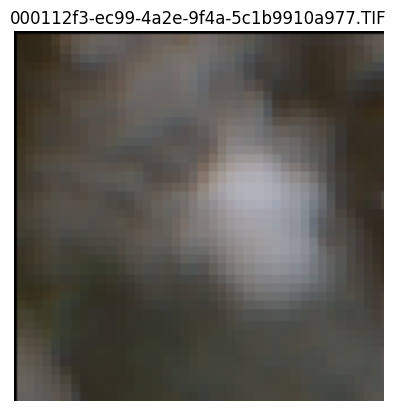


✅ D:\fadfad\Practice4\dataset\Images\Images\00043a37-a4cc-4e35-9832-3d5a6585f207.TIF
Shape: (128, 128, 4), Dtype: uint16


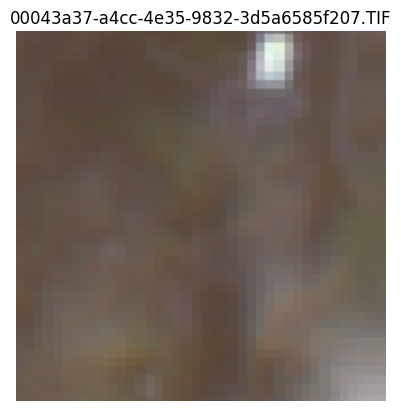


✅ D:\fadfad\Practice4\dataset\Images\Images\000f6900-98b2-4edb-b24a-d7e587de6a4f.TIF
Shape: (129, 129, 4), Dtype: uint16


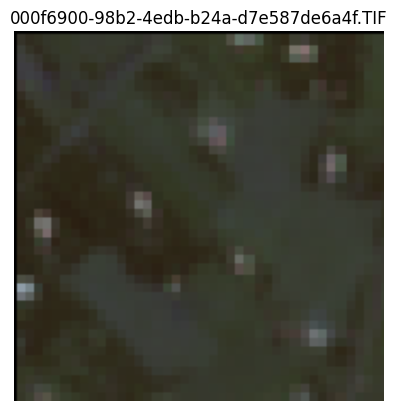


✅ D:\fadfad\Practice4\dataset\Images\Images\00111b11-bf16-4a8c-bf48-f0a355c14743.TIF
Shape: (129, 129, 4), Dtype: uint16


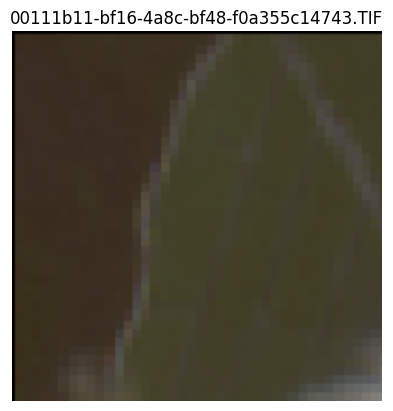


✅ D:\fadfad\Practice4\dataset\Images\Images\00141cb1-169a-4e47-a14e-1b120918f694.TIF
Shape: (128, 128, 4), Dtype: uint16


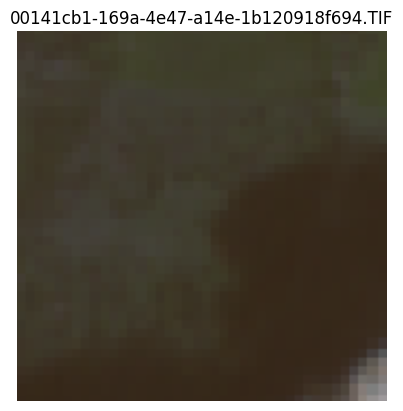

In [9]:
import matplotlib.pyplot as plt
import tifffile as tiff
import glob
import numpy as np

# Folder dataset
img_dir = r"D:\fadfad\Practice4\dataset\Images\Images"
image_paths = glob.glob(img_dir + "/*.TIF")

print(f"Jumlah gambar ditemukan: {len(image_paths)}")

for path in image_paths[:5]:
    try:
        img = tiff.imread(path)
        print(f"\n✅ {path}")
        print(f"Shape: {img.shape}, Dtype: {img.dtype}")

        # normalisasi cuma buat display
        img_display = img[..., :3] / np.max(img)

        plt.imshow(img_display)
        plt.title(path.split("\\")[-1])
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"❌ Gagal baca {path}: {e}")


Original: (128, 128, 4) uint16


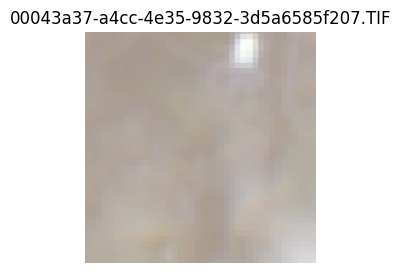

In [10]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

path = r"D:\fadfad\Practice4\dataset\Images\Images\00043a37-a4cc-4e35-9832-3d5a6585f207.TIF"

img = tiff.imread(path)
print("Original:", img.shape, img.dtype)

# ambil 3 channel pertama (RGB)
img_rgb = img[..., :3].astype(np.float32)
img_rgb /= np.max(img_rgb)  # normalisasi 0–1

plt.figure(figsize=(3,3))
plt.imshow(np.clip(img_rgb ** 0.4, 0, 1))  # gamma correction biar gak kusam
plt.title(path.split("\\")[-1])
plt.axis("off")
plt.show()
